# Welcome to the SidechainNet v1.0 Colab Walkthrough!

This notebook will guide you through several of the functionalities included in SidechainNet including:
1. Loading SidechainNet data as a SCNDataset,
2. Iterating over ProteinBatches for model training with PyTorch DataLoaders,
4. Complete model training examples.
4. Reproducing or extending SidechainNet's data.

### New in v1.0
* Streamlined data handling and representation
* Adds support for hydrogens
* Updates from our recent [paper](https://doi.org/10.1101/2023.10.03.560775) on training OpenFold to produce lower energy structures ([more info](https://github.com/jonathanking/openfold))
  - Interfaces with OpenMM for energy computation and model training
  - new `scnmin` and `scnunmin` datasets accessible via `scn.load(casp_version=12, casp_thinning={'scnmin', 'scnunmin'})`


# Installation



In [1]:
!pip install --quiet sidechainnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.5/505.5 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 9.6 MB/s eta 0:00:00


In [2]:
# A requirement for model training examples, may be skipped
!pip install --quiet pytorch_lightning

In [3]:
# To install conda in the notebook, run the 3 lines below
# Will restart notebook with conda installed
!pip install condacolab
import condacolab
condacolab.install()

# If conda is already installed, uncomment below to check installation
# import condacolab
# condacolab.check()

✨🍰✨ Everything looks OK!


In [4]:
!conda install -c conda-forge openmm cudatoolkit==11.8 # A requirement for OpenMM functionality, on 12/21/23 specified cudatoolkit version to avoid installation error

Channels:
 - conda-forge
Platform: linux-64
Solving environment: - \ | / - \ done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



# 1. Downloading data with scn.load


The cell below downloads an example version SidechainNet (called `'debug'` because it is smaller in size for demonstration purposes) as a **SCNDataset**. The data is organized under the hood as a Python dictionary, which is pickled and saved in the current directory under `./sidechainnet_data`.

If you'd like to download a full version of the SidechainNet dataset, replace the `'debug'` argument with the arguments `casp_version=12, thinning=30`.



```python
# A description of the underlying data format
d  =   {"train": {"seq": [seq1, seq2, ...],  # Sequences
                  "ang": [ang1, ang2, ...],  # Angles
                  "crd": [crd1, crd2, ...],  # Coordinates
                  "evo": [evo1, evo2, ...],  # PSSMs and Information Content
                  "sec": [sec1, sec2, ...],  # Secondary structure (DSSP)
                  "res": [res1, res2, ...],  # X-ray crystallographic resolution
                  "ids": [id1, id2,   ...],  # Corresponding ProteinNet IDs
                  },
        "valid-10": {...},
            ...
        "valid-90": {...},
        "test":     {...},
        "settings": {...},
        "description" : "SidechainNet for CASP 12."
        "date": "September 20, 2020"
        }
```

In [5]:
import sidechainnet as scn
import numpy as np

np.random.seed(0)
# d = scn.load("debug")
d = scn.load(casp_version=12, casp_thinning=30)

@> ProDy is configured: verbosity='none'


SidechainNet(12, 30) was not found in ./sidechainnet_data.


Downloaded SidechainNet to ./sidechainnet_data/sidechainnet_casp12_30.pkl.
SidechainNet was loaded from ./sidechainnet_data/sidechainnet_casp12_30.pkl.


There are many other options available when loading data. For example, you can specify which CASP competition dataset to load (CASP 7 - 12), as well as the dataset "thinning", which refers to downsampled versions of the data based on sequence similarity (`[30, 50, 70, 90, 95, 100]`, with `100` corresponding to a 100%, complete dataset).

In [6]:
# View complete documenation for scn.load by uncommenting the line below
# scn.load?

# 2. Helpful Data Structures provided by SidechainNet

## SCNDataset
When loading data with `scn.load()`, the default return type is a SCNDataset. SCNDatasets contain SCNProteins and make it easy to iterate over and inspect protein data.

In [7]:
print(d, end="\n\n")

print("Index a SCNDataset by SidechainNet ID or numerical index:")
p1 = d[5]
p2 = d[100]
print(p1)
print(p2, end="\n\n")

print("Iterate over SCNProteins in the SCNDataset, or make slices of the SCNDataset:")
for p in d[100:105]:
    print(p)

# To see a complete list of SCNDataset functions, see
# dir(d)

SCNDataset(n=25044)

Index a SCNDataset by SidechainNet ID or numerical index:
SCNProtein(3MLV_3_P, len=20, missing=7, split='train')
SCNProtein(1DVA_3_X, len=20, missing=3, split='train')

Iterate over SCNProteins in the SCNDataset, or make slices of the SCNDataset:
SCNProtein(1DVA_3_X, len=20, missing=3, split='train')
SCNProtein(1T7M_2_B, len=20, missing=8, split='train')
SCNProtein(1T7F_2_B, len=20, missing=12, split='train')
SCNProtein(2MUE_1_A, len=20, missing=0, split='train')
SCNProtein(2MU9_1_A, len=20, missing=0, split='train')


## SCNProtein

The default representation for a single protein in SidechainNet is a SCNProtein object. SCNProteins hold the all of the relevant information for a given protein, including:
* sequence
* coords (or hcoords, if hydrogens are present)
* angles (internal coordinate system)
* secondary structure, evolutionary information (if available)
* missing residue mask

These values can be accessed by the user.

SCNProtein also provides a large number of helper functions. These helper functions include:

### Examples: Interact
* fastbuild: converts internal angle representation to an all-atom coordinate representation (may also add hydrogens)
* add_hydrogens: add hydrogens to heavy atom coordinates
* copy: create a copy of the SCNProtein
* from_{cif,pdb,pkl}: create SCNProtein from a supported file format. **Does not support parsing structures with gaps from PDB or CIF files.**
* to_pdb, to_pdbstr: write SCNProtein to PDB file/string
* get_energy, get_forces: compute relevant OpenMM values for this protein
* get_atom_names: get a list of the atom names/coords for this protein for inspection
* torch, cuda, cpu, numpy: convert data to different underlying formats

### Examples: Visualize
* to_png: create an image of the protein
* to_3Dmol: open an interactive py3Dmol viewer for this protein
* to_gltf: create a 3D object (GLTF) file for this protein

In [8]:
p = d[30].copy()
print("Sequence with missing residues at the ends:")
print(p.seq)
print(p.mask)

print("\nSequence after trimming the missing residues from the edges:")
p.trim_edges()
print(p.seq)
print(p.mask)

p.to_3Dmol()

Sequence with missing residues at the ends:
VFAEFLPLFSKFGSRMHILK
++++++++++++++++++--

Sequence after trimming the missing residues from the edges:
VFAEFLPLFSKFGSRMHI
++++++++++++++++++


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [9]:
p.to_pdb(f"{p.id}.pbd")

In [10]:
!head /content/{p.id}.pbd

REMARK  pred
SEQRES   1 A   18  VAL PHE ALA GLU PHE LEU PRO LEU PHE SER LYS PHE GLY          
SEQRES   2 A   18  SER ARG MET HIS ILE                                          
ATOM      1  N   VAL A   1      29.342   4.680  19.957  1.00  0.00           N  
ATOM      2  CA  VAL A   1      28.032   4.558  19.315  1.00  0.00           C  
ATOM      3  C   VAL A   1      27.023   5.600  19.848  1.00  0.00           C  
ATOM      4  O   VAL A   1      27.051   5.931  21.040  1.00  0.00           O  
ATOM      5  CB  VAL A   1      27.516   3.080  19.280  1.00  0.00           C  
ATOM      6 CG1  VAL A   1      26.167   2.894  19.976  1.00  0.00           C  
ATOM      7 CG2  VAL A   1      27.463   2.565  17.851  1.00  0.00           C  


In [11]:
p.add_hydrogens()
p.to_3Dmol()

/usr/local/lib/python3.10/site-packages/sidechainnet/structure/HydrogenBuilder.py:267: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at ../aten/src/ATen/native/Cross.cpp:62.)
  PV = self.cross(CB, N)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [12]:
p_original = p.copy()
# Let's remove coordinates and rebuild the protein's coords from its angle representation
# If we also turn the protein into a torch tensor, we can also track gradients
# as we convert angles to cartesian coordinates! add_hydrogens and fastbuild
# are both gradient-friendly.
p.torch()
p.angles.requires_grad = True
p.coords = p.hcoords = None
print(p.angles[4:6])


tensor([[-2.1246,  2.4808,  3.1278,  1.9584,  1.9994,  2.1406,  1.9792, -1.0233,
         -1.4497,     nan,     nan,     nan],
        [-1.3176,  2.3543,  3.0819,  1.8773,  2.0729,  2.0895,  2.8578, -2.8957,
          1.3463,     nan,     nan,     nan]], dtype=torch.float64,
       grad_fn=<SliceBackward0>)


In [13]:
p.fastbuild(add_hydrogens=True, inplace=True)
p.to_3Dmol()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [14]:
# Now the hydrogen coordinates are present, and they contain gradient information
# from the coordinate generation procedure
p.hcoords[0]

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.4420e+00, -3.5319e-16, -4.3253e-32],
        [ 2.0065e+00,  1.3876e+00,  3.3986e-16],
        [ 1.4581e+00,  2.2741e+00, -6.5100e-01],
        [        nan,         nan,         nan],
        [-5.0500e-01,  8.7469e-01, -1.0712e-16],
        [-5.0500e-01, -4.3734e-01,  7.5750e-01],
        [-5.0500e-01, -4.3734e-01, -7.5750e-01],
        [ 1.9564e+00, -4.7958e-01, -1.3543e+00],
        [ 2.8438e+00,  5.9702e-01, -1.9724e+00],
        [ 2.6556e+00, -1.8255e+00, -1.1861e+00],
        [ 1.8058e+00, -6.6729e-01,  7.8130e-01],
        [ 1.1123e+00, -6.7732e-01, -2.0149e+00],
        [ 2.8996e+00,  1.4530e+00, -1.2999e+00],
        [ 3.8445e+00,  1.9581e-01, -2.1328e+00],
        [ 2.4221e+00,  9.1237e-01, -2.9268e+00],
        [ 2.6216e+00, -2.1247e+00, -1.3849e-01],
        [ 2.1511e+00, -2.5762e+00, -1.7944e+00],
        [ 3.6943e+00, -1.7383e+00, -1.5050e+00],
        [        nan,         nan,         nan],
        [        nan

In [15]:
# Since we saved the original structure, let's compare the original and the
# rebuilt structure; They may not exactly match up since rebuilding from angles
# loses some small amount of information, but they should be pretty close!
# The original protein is colored red.
print("All-atom RMSD =", p.rmsd(p_original))
p.to_3Dmol(other_protein=p_original)

All-atom RMSD = 0.9225210409386513


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [16]:
# If you want to inspect which atom is which, use get_atom_names
p.get_atom_names(zip_coords=True)

0  N    [0. 0. 0.]
1  CA   [ 1.44200003e+00 -3.53188145e-16 -4.32530731e-32]
2  C    [2.00649331e+00 1.38757033e+00 3.39856712e-16]
3  O    [ 1.4580983   2.27407969 -0.65100304]
4  OXT  [nan nan nan]
5  H    [-5.04999965e-01  8.74685634e-01 -1.07118096e-16]
6  H2   [-0.50499997 -0.43734286  0.75749995]
7  H3   [-0.50499997 -0.43734286 -0.75749995]
8  CB   [ 1.95640736 -0.47957501 -1.35427804]
9  CG1  [ 2.84382789  0.59702022 -1.97242341]
10 CG2  [ 2.65563843 -1.82547719 -1.18605374]
11 HA   [ 1.80584957 -0.66729436  0.7813014 ]
12 HB   [ 1.1122512  -0.67731597 -2.01488308]
13 HG11 [ 2.89957564  1.45296656 -1.29985503]
14 HG12 [ 3.84453836  0.19581406 -2.13277413]
15 HG13 [ 2.42214205  0.91236909 -2.92680087]
16 HG21 [ 2.62164483 -2.12473994 -0.13849161]
17 HG22 [ 2.15113967 -2.57615011 -1.79438864]
18 HG23 [ 3.69429115 -1.73826603 -1.50495017]
19 PAD  [nan nan nan]
20 PAD  [nan nan nan]
21 PAD  [nan nan nan]
22 PAD  [nan nan nan]
23 PAD  [nan nan nan]
24 PAD  [nan nan nan]
25 PAD  [nan

### OpenMM Interface

New in v1.0, we also support interfacing with OpenMM as part of our research [paper](https://www.biorxiv.org/content/10.1101/2023.10.03.560775v1). To read more about using the methods from that paper, see its corresponding [repo](https://github.com/jonathanking/openfold), which works in tandem with SidechainNet.

In [17]:
# Compute a protein's energy with OpenMM
# Be careful, the protein can't be missing any atoms, as many of the proteins
# in SidechainNet are! Fortunately, most protein structure predictions are
# never missing atoms.
p = d[2]
p.cuda()
p.trim_edges()
p.angles.requires_grad = True # This is for the example below with gradients
p.fastbuild(add_hydrogens=True, inplace=True)
p.get_energy()

Quantity(value=888.1702336590201, unit=kilojoule/mole)

In [18]:
# We can also use OpenMM to query the forces acting on the atoms
# according to a specified forcefield
from sidechainnet.dataloaders.SCNProtein import OPENMM_FORCEFIELDS

print("ForceFields:", OPENMM_FORCEFIELDS, end="\n\n")
p.get_forces()

ForceFields: ['amber14/protein.ff15ipq.xml', 'implicit/gbn.xml']



array([[-4.92920086e+02, -3.25656116e+00,  1.81813898e+01],
       [ 1.18421724e+02, -7.93132232e+01, -1.30647734e+02],
       [-2.44790932e+03,  1.10229135e+03,  2.00791108e+03],
       [-8.39927437e+01,  1.26439893e+01,  8.21630852e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 9.75336221e+01,  7.51632340e+01, -1.97750512e+00],
       [ 9.29310913e+01, -3.25674924e+01,  6.14548749e+01],
       [ 9.33547441e+01, -3.45171971e+01, -5.45156219e+01],
       [-6.22854903e+00, -1.11843462e+02,  5.08821605e+01],
       [ 1.74399962e+02, -2.23211726e+02, -3.93302308e+02],
       [ 2.67876791e+01, -8.86169766e-01,  5.10341984e+01],
       [ 7.94114431e+01,  1.19281047e+02, -1.73037111e+02],
       [-4.78173131e+01, -3.90236367e+01, -9.59035721e+01],
       [ 4.03207121e+01,  3.25139832e+01,  2.16494821e+01],
       [-6.47134153e+01, -9.69953188e+01,  1.00701165e+02],
       [-5.40961955e+00, -6.02508458e+00, -2.32992535e+00],
       [ 1.79846282e+00,  2.12585953e-01

#### Gradient Friendly OpenMM Energy Computation
You can also compute the OpenMM-Loss, which is gradient-friendly!
Providing you have a SCNProtein with no missing atoms, you can use this
method to compute energy as a loss function, and then call backwards
to minimize this value. By default, we apply two smoothing functions
(one is a modified sigmoid, and another is simlar to a ReLU).

If your SCNProtein's coordinates (or angles) were predicted by
a PyTorch model and thus contain gradients, then the computation
graph will be completely unbroken between the model and the energy loss.

In [19]:
loss = p.get_openmm_loss()
print(loss)

# To compute the gradients in preparation for an optimization step,
# just call loss.backward()!
loss.backward()

tensor(0.2526, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


In this case, since we converted angles to coordinates, `p.angles` is
our "leaf" tensor, and its 'grad' attribute has been populated.
In other words, `p.angles.grad` explains how to change the angles of the protein
in order to minimize the loss function (i.e., energy).

In [20]:
p.angles.grad[:2]

tensor([[ 0.0000,  0.0742, -0.0016,  0.1025, -0.0080, -0.0020,  0.0000, -0.0149,
         -0.0088, -0.0001,     nan,     nan],
        [-0.0003, -0.0010,     nan, -0.0002,     nan,     nan,  0.0012,     nan,
             nan,     nan,     nan,     nan]], device='cuda:0',
       dtype=torch.float64)

## ProteinBatch

An important function of SidechainNet is making this data accessible for machine learning in PyTorch. We make it simple to load the data as PyTorch Dataloaders which can be iterated over. At each step of the iteration, the user can access the ProteinBatch object which handles the data collation and tensor creation.

When you load the data, determine the desired batch size, or select dynamic_batching=True to have a variable batch size with a near-constant level of amino acids.

In [21]:
# Let's reload the dataset as a dict of PyTorch Dataloaders
dataloaders = scn.load('debug',
                       batch_size=4,
                       with_pytorch='dataloaders')


SidechainNet('debug', 30) was not found in ./sidechainnet_data.


Downloaded SidechainNet to ./sidechainnet_data/sidechainnet_debug.pkl.
SidechainNet was loaded from ./sidechainnet_data/sidechainnet_debug.pkl.


In [22]:
# Now, we have access to the dataset splits defined by SidechainNet.
# Let's list them:
for split, dataloader in dataloaders.items():
    print(split, "\n   ", dataloader.dataset)

train 
    SCNDataset(n=195, split=train)
train-eval 
    SCNDataset(n=195, split=train)
test 
    SCNDataset(n=39, split=test)
valid-10 
    SCNDataset(n=30, split=valid-10)
valid-20 
    SCNDataset(n=30, split=valid-20)
valid-30 
    SCNDataset(n=32, split=valid-30)
valid-40 
    SCNDataset(n=32, split=valid-40)
valid-50 
    SCNDataset(n=31, split=valid-50)
valid-70 
    SCNDataset(n=30, split=valid-70)
valid-90 
    SCNDataset(n=31, split=valid-90)


In [23]:
# We can iterate over any split of the dataloader to yield ProteinBatches for
# training or evaluating; each item is padded when accessed via the ProteinBatch
for batch in dataloaders['train']:
    break

print(batch, end="\n\n")
print("Protein IDs\n   ", batch.ids)
print("Sequences\n   ", batch.seqs.shape)
print("Evolutionary Data\n   ", batch.evolutionary.shape) # Since these come from ProteinNet, they may not be present
print("Secondary Structure\n   ", batch.secondary.shape)  # Since these come from ProteinNet, they may not be present
print("Angle Data\n   ", batch.angles.shape)
print("Coordinate Data\n   ", batch.coords.shape)
print("X-ray Resolution\n   ", batch.resolutions) # May not be present

ProteinBatch(n=4, max_len=158)

Protein IDs
    ['1KZY_d1kzyd1', '2I83_1_A', '3N08_1_A', '2B0O_d2b0of2']
Sequences
    torch.Size([4, 158, 20])
Evolutionary Data
    torch.Size([4, 158, 21])
Secondary Structure
    torch.Size([4, 158, 8])
Angle Data
    torch.Size([4, 158, 12])
Coordinate Data
    torch.Size([4, 158, 15, 3])
X-ray Resolution
    [2.5, None, 1.25, 2.06]


### Padding
Padding is essential in machine learning when you want to do mini-batch training and have data of different lengths or shapes.

We believe that for research purposes, `NaN` padding is helpful to represent missing values, and this is the default padding character we use. However, neural network inputs cannot contain `NaN`s, and they will fail if they try to compute on `NaN` values.

Hence, we recommend keeping the `NaN` padding in place except for when you need to train a machine learning model. In that case, you can use `SCNProtein.fillna` or `ProteinBatch.fillna` to replace `NaN`s with a different value.

Here's an example with a ProteinBatch. Notice how the batch's `NaN` values get filled with our `fillna` function, but the underlying SCNProtein values keep their `NaN`s to represent missing values.

In [24]:
# We start with a typical batch, contains NaNs everywhere for missing
# values and padding
batch_filled_nan = batch.copy()
batch_filled_nan.angles

tensor([[[    nan, -0.0078, -3.1250,  ...,     nan,     nan,     nan],
         [-1.6788, -0.4438,  3.1173,  ...,     nan,     nan,     nan],
         [-1.3267, -0.5606, -3.1353,  ..., -0.7465,     nan,     nan],
         ...,
         [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
         [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
         [    nan,     nan,     nan,  ...,     nan,     nan,     nan]],

        [[    nan,  0.4690,  3.1412,  ..., -0.1934,     nan,     nan],
         [-2.2106,  2.5096,  3.1395,  ...,  3.1263,     nan,     nan],
         [-2.1870,  2.6625,  3.1415,  ...,     nan,     nan,     nan],
         ...,
         [-2.8564,  2.3489, -3.1413,  ...,     nan,     nan,     nan],
         [-2.2111,  2.6413, -3.1413,  ...,     nan,     nan,     nan],
         [-1.4026,  1.9238,     nan,  ...,     nan,     nan,     nan]],

        [[    nan,  0.5255, -3.0802,  ...,     nan,     nan,     nan],
         [-1.1242,  2.4762,  3.0726,  ...,   

In [25]:
# We fill tha NaNs in the batch with zeros to facilitate model training
batch_filled_nan.fillna(0.0)
batch_filled_nan.angles

tensor([[[ 0.0000, -0.0078, -3.1250,  ...,  0.0000,  0.0000,  0.0000],
         [-1.6788, -0.4438,  3.1173,  ...,  0.0000,  0.0000,  0.0000],
         [-1.3267, -0.5606, -3.1353,  ..., -0.7465,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.4690,  3.1412,  ..., -0.1934,  0.0000,  0.0000],
         [-2.2106,  2.5096,  3.1395,  ...,  3.1263,  0.0000,  0.0000],
         [-2.1870,  2.6625,  3.1415,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [-2.8564,  2.3489, -3.1413,  ...,  0.0000,  0.0000,  0.0000],
         [-2.2111,  2.6413, -3.1413,  ...,  0.0000,  0.0000,  0.0000],
         [-1.4026,  1.9238,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.5255, -3.0802,  ...,  0.0000,  0.0000,  0.0000],
         [-1.1242,  2.4762,  3.0726,  ...,  0

In [26]:
# Looking at the first SCNProtein in the batch, it maintains its NaNs
# for research purposes/to denote missing values even though the
# ProteinBatch has filled these values for model training.
batch_filled_nan[0].angles

array([[        nan, -0.00782439, -3.12495206, ...,         nan,
                nan,         nan],
       [-1.67875429, -0.44378003,  3.11728732, ...,         nan,
                nan,         nan],
       [-1.32670185, -0.56056744, -3.13532608, ..., -0.74653713,
                nan,         nan],
       ...,
       [-0.86428878,  2.5694312 , -3.1306065 , ...,         nan,
                nan,         nan],
       [-2.7752675 ,  2.80837726,  3.08365061, ..., -1.25276444,
        -1.48483973, -0.01667991],
       [-1.37213755, -0.241764  ,         nan, ..., -1.29682823,
                nan,         nan]])

In [27]:
# Notice that the proteins in the batch have difference lengths
for p in batch:
    print(len(p))

153
158
151
153


In [28]:
# This isn't a problem, however, as ProteinBatch pads tensors with
# sidechainnet.structure.build_info.GLOBAL_PAD_CHAR.

# If needed, modify the line below to look at the last coordinate from
# one of the shorter proteins in the batch.
# index into the coords variable via (Batch, protein length, num_coords_per_residue, 3)
batch.coords[1, -1]

tensor([[60.8090,  3.2950, 28.3360],
        [62.0790,  2.6350, 28.6140],
        [62.2410,  2.3610, 30.1050],
        [62.2000,  1.2120, 30.5430],
        [    nan,     nan,     nan],
        [63.2710,  3.4810, 28.1260],
        [63.3250,  4.8070, 28.8700],
        [64.5730,  2.7130, 28.2940],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan]])

In [29]:
# Sequences can be accessed in one-hot or integer representations (which may)
# be helpful if using PyTorch embedding layers
print("Integer sequence")
print("\tShape:", batch.seqs_int.shape)
print("\tEx:", batch.seqs_int[0,:3])

print("1-hot sequence")
print("\tShape:", batch.seqs.shape)
print("\tEx:\n", batch.seqs[0,:3])


Integer sequence
	Shape: torch.Size([4, 158])
	Ex: tensor([0, 9, 3])
1-hot sequence
	Shape: torch.Size([4, 158, 20])
	Ex:
 tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


**Sequence padding**

Sequences, when expressed as integer sequences, include a specific character (`20`) to represent batch-level padding. This isn't necessary for one-hot vectors, an all-zero vector with the same dimension can represent the same information. This is handled in SidechainNet.

In [30]:
# Default integer sequence representation uses the int 20 for padding
# Example: observe the last amino-acid 'characters' of the same protein above
# which has been padded with 20s to match the batch size
batch.seqs_int[1, -15:]

tensor([11, 12,  3,  2,  7, 19, 12, 15, 11, 12, 16,  2,  2,  2, 17])

We can see that, when batch-level padding is included in a one-hot-encoded sequence, it ends in several zero-vectors.

In [31]:
# By summing over the last dimension of the sequence, we can see
# the last several one-hot vectors contain all zeros for padding
batch.seqs[1, -15:].sum(axis=1)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## Dynamic Batch Sizes

With `dynamic_batching=True` (`False` by default), the DataLoader yields batches that attempt to have `batch_size * average_sequence_length` residues in it. Using this soft constraint, the DataLoader yields batches with more proteins when their lengths are small, and batches with fewer proteins when their lengths are large. Yielding proteins of similar length may speed up computation and allow better GPU utilization.

In [32]:
# Let's try an approximate batch size of 4, which when accounting for average
# sequence length is about 176 * 4 = 704 residues per batch
d = scn.load('debug',
             with_pytorch='dataloaders',
             dynamic_batching=True,
             batch_size=4)
i = 0
for batch in d['train']:
    print(f"    Current batch shape = {tuple(batch.seqs.shape)}; Total residues = "
          f"{batch.seqs.shape[0] * batch.seqs.shape[1]}.")
    i += 1
    if i >= 5:
        break


# Now let's change the approximate batch size to 8, which when accounting for
# average sequence length is about 176 * 8 = 1408 residues per batch
d = scn.load('debug',
             with_pytorch='dataloaders',
             dynamic_batching=True,
             batch_size=8)
i = 0
for batch in d['train']:
    print(f"    Current batch shape = {tuple(batch.seqs.shape)}; Total residues = "
          f"{batch.seqs.shape[0] * batch.seqs.shape[1]}.")
    i += 1
    if i >= 5:
        break

SidechainNet was loaded from ./sidechainnet_data/sidechainnet_debug.pkl.
Approximating 704 residues/batch.
    Current batch shape = (6, 123, 20); Total residues = 738.
    Current batch shape = (4, 177, 20); Total residues = 708.
    Current batch shape = (3, 209, 20); Total residues = 627.
    Current batch shape = (1, 385, 20); Total residues = 385.
    Current batch shape = (1, 454, 20); Total residues = 454.
SidechainNet was loaded from ./sidechainnet_data/sidechainnet_debug.pkl.
Approximating 1408 residues/batch.
    Current batch shape = (2, 602, 20); Total residues = 1204.
    Current batch shape = (1, 656, 20); Total residues = 656.
    Current batch shape = (5, 249, 20); Total residues = 1245.
    Current batch shape = (1, 890, 20); Total residues = 890.
    Current batch shape = (14, 103, 20); Total residues = 1442.


# Sidechain Torsion Angle Prediction Example

Below you will find an example of using `sidechainnet` to train machine learning models to predict protein structure from amino acid sequences. Our model will take amino acid sequences as input and try to predict sidechain angles only. It will be trained with Mean Squared Error (MSE) on sin/cos transformed angles. We will skip structure generation during training as a simplification.




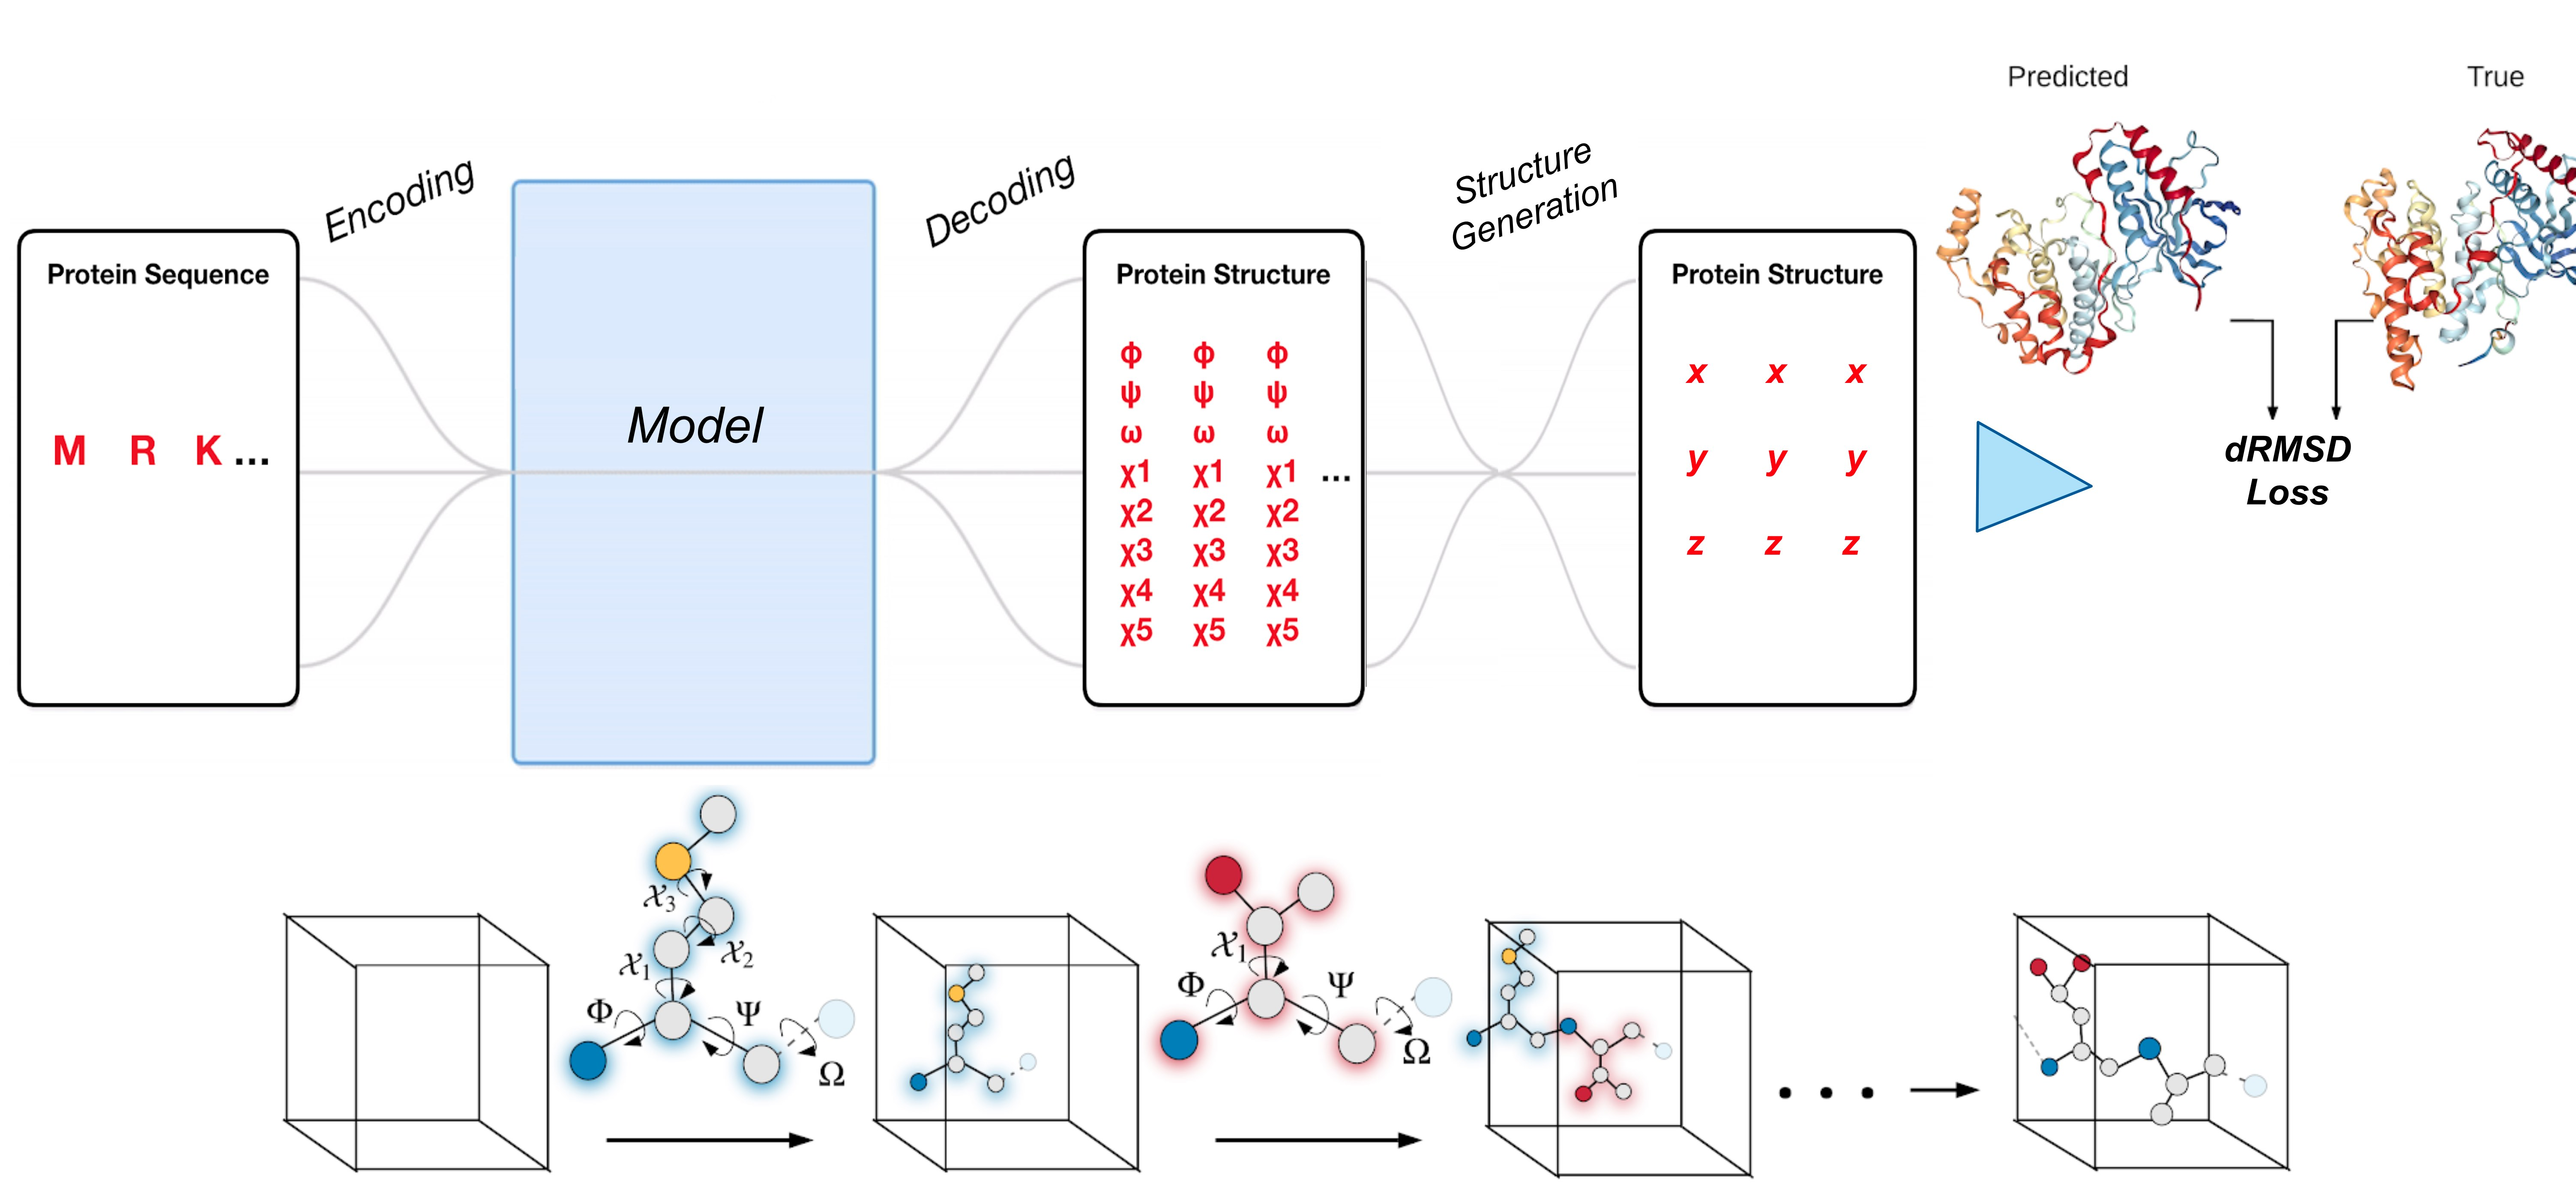



Our model is defined as:

* input =
    * one-hot encoded sequence ($BatchSize\times Length\times ℝ^{20}$)
    * backbone angles ($BatchSize\times Length\times ℝ^{6}$)
    * PSSMs ($BatchSize\times Length\times ℝ^{21}$)
        * PSSMs (Position Specific Scoring Matrices) summarize how often a residue is observed at a given sequence position. Below is an example of a PSSM (in this case called a Position Probability Matrix/PPM) for a DNA sequence.

        * ![](https://wikimedia.org/api/rest_v1/media/math/render/svg/6940f505c03de60ce26b4f89b9f1e9f867b714c8)
    * secondary structure ($BatchSize\times Length\times ℝ^{8}$)
* output =
    * sidechain angles (sin/cos)  ($BatchSize\times Length\times ℝ^{12}$).


Each of the 6 output angles is decomposed into its `sin` and `cos` components, $(s, c)$. After prediction, the true angle can be recovered with the formula $\chi = \text{atan2}(\sin(s), \cos(c))$.

## Code import and model definition

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning import callbacks
import torch
from tqdm.notebook import tqdm

import sidechainnet as scn
from sidechainnet.structure.structure import inverse_trig_transform
from sidechainnet.structure.build_info import NUM_ANGLES
from sidechainnet.examples.lightning.LitSidechainDemo import LitSidechainTransformerBaseModule, LitSCNDataModule
from sidechainnet.examples.transformer import PositionalEncoding
from sidechainnet.utils.sequence import VOCAB
from sidechainnet.utils.download import MAX_SEQ_LEN
from sidechainnet.dataloaders.SCNProtein import SCNProtein
from sidechainnet.dataloaders.ProteinBatch import ProteinBatch

# To train with a GPU, go to Runtime > Change runtime type
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
print(f"Using {device} for training.")

Using cuda for training.


In [34]:
class LitSidechainTransformerDemo(LitSidechainTransformerBaseModule):
    """PyTorch Lightning module for SidechainTransformer."""

    def __init__(
            self,
            # Model specific arguments
            d_seq_embedding=20,
            d_nonseq_data=35,  # 5 backbone angles, 21 PSSM, 8 secondary structure
            d_in=256,
            d_out=12,
            d_feedforward=1024,
            n_heads=8,
            n_layers=1,
            transformer_activation='relu',
            sequence_only=True,
            # Training Arguments
            loss_name='mse',
            opt_name='adam',
            opt_lr=1e-2,
            opt_lr_scheduling='plateau',
            opt_lr_scheduling_metric='val_loss',
            opt_patience=5,
            opt_min_delta=0.01,
            opt_weight_decay=1e-5,
            opt_n_warmup_steps=5_000,
            dropout=0.1,
            # Other
            dataloader_name_mapping=None,
            angle_means=None,
            **kwargs):
        """Create a LitSidechainTransformer module."""
        super().__init__()
        self.automatic_optimization = True
        self.save_hyperparameters()

        # Initialize layers
        self.input_embedding = torch.nn.Embedding(len(VOCAB),
                                                  d_seq_embedding,
                                                  padding_idx=VOCAB.pad_id)
        if sequence_only:
            self.ff1 = torch.nn.Linear(d_seq_embedding, d_in)
        else:
            self.ff1 = torch.nn.Linear(d_nonseq_data + d_seq_embedding, d_in)
        self.positional_encoding = PositionalEncoding(d_model=d_in,
                                                      max_len=MAX_SEQ_LEN)
        self.encoder_layer = torch.nn.TransformerEncoderLayer(
            d_model=d_in,
            nhead=n_heads,
            dim_feedforward=d_feedforward,
            dropout=dropout,
            activation=transformer_activation,
            batch_first=True,
            norm_first=True)
        self.transformer_encoder = torch.nn.TransformerEncoder(self.encoder_layer,
                                                               num_layers=n_layers)
        self.ff2 = torch.nn.Linear(d_in, d_out)
        self.output_activation = torch.nn.Tanh()

        # Initialize model parameters
        self._init_parameters()
        if angle_means is not None:
            self._init_angle_mean_projection()

    def forward(self, x, seq):
        """Run one forward step of the model."""
        seq = seq.to(self.device)
        padding_mask = self._get_seq_pad_mask(seq)
        seq = self.input_embedding(seq)
        if self.hparams.sequence_only:
            x = seq
        else:
            x = torch.cat([x, seq], dim=-1)
        x = self.ff1(x)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x, src_key_padding_mask=padding_mask)
        x = self.ff2(x)
        x = self.output_activation(x)
        return x

    def _prepare_model_input(self, batch):
        batch.set_device(self.device)
        # True values still have nans, replace with 0s so they can go into the network
        batch.fillna(0.0)
        # Also select out backbone and sidechain angles
        bb_angs = batch.angles[:, :, :6]
        sc_angs_true_untransformed = batch.angles[:, :, 6:]

        # Result after transform (6 angles, sin/cos): (B x L x 12)
        sc_angs_true = scn.structure.trig_transform(sc_angs_true_untransformed).reshape(
            sc_angs_true_untransformed.shape[0], sc_angs_true_untransformed.shape[1], 12)

        # Stack model inputs into a single tensor
        model_in = torch.cat([bb_angs, batch.secondary, batch.evolutionary], dim=-1)

        return model_in, sc_angs_true

    def training_step(self, batch, batch_idx):
        """Perform a single step of training (model in, model out, log loss).

        Args:
            batch (List): List of Protein objects.
            batch_idx (int): Integer index of the batch.
        """
        model_in, sc_angs_true = self._prepare_model_input(batch)

        # Predict sidechain angles given input and sequence
        sc_angs_pred = self(model_in, batch.seqs_int)  # ( B x L x 12)

        # Compute loss and step
        loss_dict = self._get_losses(batch,
                                     sc_angs_true,
                                     sc_angs_pred,
                                     do_struct=batch_idx == 0,
                                     split='train')
        self.log(
            'losses/train/rmse',
            torch.sqrt(loss_dict['mse']),
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            batch_size=len(batch)
        )

        self.log("trainer/batch_size", float(len(batch)), on_step=True, on_epoch=False)
        self._log_angle_metrics(loss_dict, 'train', len(batch))

        if loss_dict['loss'] is None:
            return None

        return loss_dict


## Training Arguments and Model Training

In [35]:
model_args = {
              # Model architecture
              "sequence_only": False,
              "d_seq_embedding":20,
              "d_in":1024,
              "d_feedforward":1024,
              "n_heads":4,
              "n_layers":2,
              "transformer_activation":'relu',

              # Model Training
              "batch_size": 4,
              "opt_n_warmup_steps":3000,
              "opt_lr":1e-2,
              "opt_lr_scheduling":'noam',
              "opt_noam_lr_factor": .75,
              "opt_weight_decay":1e-5,
              "dropout":0.1,
              "log_structures": False
    }

assert model_args["d_in"] % model_args["n_heads"] == 0,\
     "Please make d_in divisible by n_heads"

In [36]:
# Make it reproducible!
pl.seed_everything(10701)

# Load dataset (a datamodule is just another wrapper)
# Feel free to load a larger dataset, like `casp_version=12, casp_thinning=30`
data = scn.load("debug", with_pytorch='dataloaders', batch_size=model_args['batch_size'])
data_module = LitSCNDataModule(data, batch_size=model_args['batch_size'])

# Update args with dataset information
model_args["angle_means"] = data_module.get_train_angle_means(6, None)
model_args["dataloader_name_mapping"] = data_module.val_dataloader_idx_to_name

# Prepare model
model = LitSidechainTransformerDemo(**model_args)

# Make callbacks
my_callbacks = []
my_callbacks.append(callbacks.LearningRateMonitor(logging_interval='step'))

Seed set to 10701


SidechainNet was loaded from ./sidechainnet_data/sidechainnet_debug.pkl.


/usr/local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [37]:
# Create a trainer
trainer = pl.Trainer(callbacks=my_callbacks,
                    #  logger=wandb_logger,      # if you have a wandb acct
                     max_epochs=100,
                     log_every_n_steps=10,
                     check_val_every_n_epoch=15)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [38]:
# Train the model
trainer.fit(model, data_module)

Missing logger folder: /content/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                    | Params
----------------------------------------------------------------
0 | input_embedding     | Embedding               | 420   
1 | ff1                 | Linear                  | 57.3 K
2 | positional_encoding | PositionalEncoding      | 0     
3 | encoder_layer       | TransformerEncoderLayer | 6.3 M 
4 | transformer_encoder | TransformerEncoder      | 12.6 M
5 | ff2                 | Linear                  | 12.3 K
6 | output_activation   | Tanh                    | 0     
----------------------------------------------------------------
19.0 M    Trainable params
0         Non-trainable params
19.0 M    Total params
75.901    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [47]:
best_checkpoint_path = trainer.checkpoint_callback.best_model_path
print(best_checkpoint_path)

# Make sure to use the class name of your model, not the instance
best_model_class = LitSidechainTransformerDemo
best_model = best_model_class.load_from_checkpoint(best_checkpoint_path)

# Save the model state_dict as a .pt file
torch.save(best_model.state_dict(), 'best_model.pt')

/content/lightning_logs/version_0/checkpoints/epoch=89-step=5310.ckpt


## Inspecting Model Predictions

To look at a prediction from our test set, we'll do the following (*it's easier than it looks, just requires some data juggling since we're A: only predicting sidechain angles, and B: predicting the sins and coss of those angles*):

1. Use the trained model to predict sidechain angles (predicted as sin/cos values).
2. Converting them to radians (`inverse_trig_transform`)
3. Create ProteinBatch objects to hold the true proteins and the predicted proteins.
4. Fill the sidechain torsion angles into the predicted ProteinBatch's SCNProteins.
5. Use the predicted angles and SCNProtein.`fastbuild` to convert torsion angles to cartesian coordinates.
6. Finally, we can compare predicted the structures.

In [39]:
for batch in data['test']:
    model_in, _ = model._prepare_model_input(batch)
    sc_angs_pred = model(model_in, batch.seqs_int)  # predict sin/cos of sidechain angles ( B x L x 12)
    sc_angs_pred = inverse_trig_transform(sc_angs_pred, n_angles=6)  # transform sin/cos into radians (B x L x 6)
    break

# Setup comparison ProteinBatches
true_batch = batch.copy()
predicted_batch = batch.copy()
for i, (sc_angs, predicted_protein, true_protein) in enumerate(zip(sc_angs_pred, predicted_batch, true_batch)):
    # Fill in the predicted angles
    predicted_protein.angles[:, 6:] = sc_angs.cpu().detach().numpy()[i, :len(true_protein)]
    # Convert predicted angles to coordinates
    predicted_protein.fastbuild(inplace=True)

print(true_batch)
print(predicted_batch)

ProteinBatch(n=4, max_len=101)
ProteinBatch(n=4, max_len=101)


In [56]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

In [64]:
predicted_batch[1].to_3Dmol()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [41]:
true_batch[1].to_3Dmol(other_protein=predicted_batch[1])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [42]:
from sidechainnet.examples.losses import gdc_all

# Inspecting Structure Metrics

true_batch[1].numpy()
predicted_batch[1].numpy()
pad_locations = np.isnan(true_batch[1].coords)
true_coords = true_batch[1].coords[~pad_locations]
pred_coords = predicted_batch[1].coords[~pad_locations]

print("GDC-All (like GDT-TS but for all-atom structures):\t",
      gdc_all(true_coords.reshape(-1, 3), pred_coords.reshape(-1, 3)))

print("All-atom RMSD:\t\t\t\t\t\t ", true_batch[1].rmsd(predicted_batch[1]))

GDC-All (like GDT-TS but for all-atom structures):	 73.38842975206612
All-atom RMSD:						  2.108740075966564


# Reproducing and Extending SidechainNet

## Generating a custom version of SidechainNet

If you would like to modify SidechainNet's organization or composition, we provide several tools to help. You'll be able to specify which proteins to download and what dataset split to assign them to. You may even construct an arbitrary number of validation splits or add proteins that were previously excluded from ProteinNet/SidechainNet (e.g., recently released protein structures).

The only requirement is that you provide a list of ProteinNet-formatted IDs.

The ProteinNet format is as follows:
> `<class>#<pdb_id>_<chain/model_number>_<chain_id>`

*   `class`: Determines dataset split assignment.
   - If `class` is empty *and the `#` is omitted*, then the ID is treated as a training set entry.
   - If `class` is an integer (`3,10,70,49` etc.), then the ID is assigned to a validation set named `'valid-class'`, (i.e. `'valid-3'`).
   - If `class` is any of `'TBM, FM, TBM-hard, FM-hard, Unclassified'`, then the ID is assigned to the test set.
*   `<pdb_id>`: 4-letter RSCB PDB identifier (`1A9U`)
*   `<chain_number>`: integer describing the chain/model number/coordinate set entry (using 1 is a reasonable default if you are unsure)
*   `<chain_id>`: 1-letter chain name (`A`, `B`, etc.)



### Creating a list of ProteinNet IDs

Let's say we would like to generate a dataset that utilizes:

* the 30% training set thinning from ProteinNet's CASP12 dataset (for this example we will simply load the first 50 IDs),
* only the `'valid-10'` and `'valid-90'` validation sets from CASP12, and  
* the testing set from CASP11.

This way, we can see how a model might perform retroactively on CASP11 if we had access to CASP12 data.  We also want to update SidechainNet to include a recently published protein structure, in this case an Immunity-related GTPase from a [house mouse subspecies](https://www.google.com/search?q=%22Mus+musculus+molossinus%22&newwindow=1&sxsrf=ALeKk01Fq0f1pNwSynwRs74GLPwdOHf4jQ:1619451753106&source=lnms&tbm=isch&sa=X&ved=2ahUKEwjv0uXzn5zwAhVWJzQIHcNvC58Q_AUoAXoECAEQAw&biw=1672&bih=1338) ([7C3K](https://www.rcsb.org/structure/7C3K), chain A, coordinate set 1). In ProteinNet format, this entry would be `'7C3K_1_A'`.

To do this, the first step is to compile a list of relevant ProteinNet IDs for our dataset. We can write them programmatically/by hand, or we can utilize `sidechainnet.get_proteinnet_ids()`, which loads the ProteinNet IDs in use by previous versions of ProteinNet.


In [ ]:
import sidechainnet as scn

In [ ]:
# Acquire the first 50 IDs from the correct ProteinNet CASP version
training_ids = scn.get_proteinnet_ids(casp_version=12, split="train", thinning=30)[:50]

# Add a new protein ID, not previously included in ProteinNet/SidechainNet
training_ids = ['7C3K_1_A'] + training_ids
training_ids[:5]

['7C3K_1_A', '12AS_1_A', '16VP_1_A', '1914_1_A', '1A04_1_A']

In [ ]:
valid_ids = scn.get_proteinnet_ids(casp_version=12, split="valid-10")
valid_ids += scn.get_proteinnet_ids(casp_version=12, split="valid-90")
valid_ids[:5]

['10#1HF2_1_A', '10#1JB0_12_X', '10#1WAZ_1_A', '10#1Z9V_1_A', '10#2EEM_1_A']

In [ ]:
test_ids = scn.get_proteinnet_ids(casp_version=12, split="test")
test_ids[:5]

['FM#T0859', 'FM#T0862', 'FM#T0863', 'FM#T0864', 'FM#T0866']

###  Using `scn.create_custom` to generate the data
Now we are ready to generate our custom SidechainNet dataset with `scn.create_custom`. Please note that due to constraints on computing resources (storage, memory, n_cpus), we strongly recommend that this procedure be completed outside of Colab on a machine with multiple available CPUs.

In [ ]:
dset = scn.create_custom(pnids=training_ids + valid_ids + test_ids,
                         output_filename="custom01.pkl",
                         short_description="CASP12 data with the exception of CASP11's test set.")

BadZipFile: File is not a zip file

Right away, we are ready to investigate the data, which has been returned as a SCNDataset organized by dataset split. We can also check that our training set now includes the just-released protein structure 7C3K.

In [ ]:
dset

SCNDataset(n=152)

In [ ]:
'7C3K_1_A' in dset

True

### Loading the custom dataset in alternative formats (PyTorch)
Now that the data has been generated, we can load the data in a format that is more amenable for training machine learning models. For instance, we will now load the data with PyTorch Dataloaders, which handles dataset batching, padding, and organization.

In [ ]:
dl = scn.load(local_scn_path="sidechainnet_data/custom01.pkl",
              with_pytorch="dataloaders",
              batch_size=4)
dl.keys()

SidechainNet was loaded from sidechainnet_data/custom01.pkl.


dict_keys(['train', 'train-eval', 'test', 'valid-10', 'valid-90'])

In [ ]:
training_dl = dl['train']
valid_dl = dl['valid-10']
testing_dl = dl['test']

In [ ]:
train_batch = next(iter(training_dl))
print("Available attributes/properties:")
dir(train_batch)

Available attributes/properties:


['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_angles',
 '_coords',
 '_fillna',
 '_get_seqs',
 'angles',
 'coords',
 'copy',
 'cpu',
 'cuda',
 'device',
 'evolutionary',
 'fillna',
 'ids',
 'is_modified',
 'masks',
 'max_len',
 'pad_for_batch',
 'proteins',
 'pssm',
 'resolutions',
 'secondary',
 'seqs',
 'seqs_int',
 'seqs_onehot',
 'set_device',
 'torch',
 'trim_ends']

## Reproducing SidechainNet with `scn.create`

In the case that the user would like to generate SidechainNet data from scratch, please
use `scn.create` for a single CASP/thinning or `scn.generate_all` to create all possible datasets.


ProteinNet and SidechainNet are organized into several different datasets depending on the
CASP version number and the training set thinning. Simply call `scn.create` and SidechainNet
will download a minimally preprocessed version of ProteinNet into
`sidechainnet/resources/proteinnet_parsed` (this need not be accessed directly by the user).
 Then, SidechainNet will download the relevant proteins from RCSB PDB and unify this data
 with several dataset features from ProteinNet (e.g., secondary structury and
position-specific scoring matrices). Finally, the data can be loaded with `scn.load`.

As with generating a custom version of SidechainNet, reproducing SidechainNet is also
computationally expensive and we suggest performing this operation outside of Colab.


In [ ]:
scn.create?

In [ ]:
scn.create(casp_version=12, thinning=30)

In [ ]:
data = scn.load(casp_version=12, thinning=30)

# Getting in touch
If you have any questions, concerns, or comments, please reach out to us on the [GitHub repository page](https://github.com/jonathanking/sidechainnet). Thank you!